In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from windrose import WindroseAxes
import numpy as np
import os
import glob

In [29]:
def process_csv_data(directory_path):
    # List to hold all individual dataframes
    all_dataframes = []

    # Get all CSV files from the directory
    csv_files = glob.glob(os.path.join(directory_path, "*.csv"))

    # Iterate through each CSV file and process it
    for file_path in csv_files:
        # Read the CSV file without combining dates
        df = pd.read_csv(file_path, sep=';')

        # Rename columns
        df.columns = ['Data', 'Hora (UTC)', 'temp', 'humidity', 'pressure', 'wind_speed', 'wind_dir', 'cloudiness', 'insolation', 'max_temp', 'min_temp', 'rainfall']

        # Combine 'Data' and 'Hora (UTC)' into a single 'datetime' column after reading
        df['datetime'] = pd.to_datetime(df['Data'] + ' ' + df['Hora (UTC)'].astype(str).str.zfill(4), format='%d/%m/%Y %H%M')

        # Convert wind speed from m/s to knots and ensure it's numeric
        df['wind_speed'] = pd.to_numeric(df['wind_speed'].str.replace(',', '.'), errors='coerce') * 1.94384

        # Ensure wind direction is numeric
        df['wind_dir'] = pd.to_numeric(df['wind_dir'].str.replace(',', '.'), errors='coerce')

        # Drop rows with NaN values in wind speed or direction
        df = df.dropna(subset=['wind_speed', 'wind_dir'])

        # Append the dataframe to the list of dataframes
        all_dataframes.append(df)

    # Concatenate all dataframes into a single one
    combined_df = pd.concat(all_dataframes, ignore_index=True)

    # Drop any remaining NaNs, if they exist
    combined_df = combined_df[combined_df['wind_speed'].notna() & combined_df['wind_dir'].notna()]

    return combined_df


In [30]:
def create_wind_rose(wind_speed, wind_dir, title, ax=None):
    if ax is None:
        ax = WindroseAxes.from_ax()
    # Avoid NaNs during plotting
    wind_speed_clean = wind_speed.dropna()
    wind_dir_clean = wind_dir.dropna()

    # Create windrose plot
    ax.bar(wind_dir_clean, wind_speed_clean, opening=0.8, edgecolor='white')
    ax.set_legend(title="Wind speed (knots)")
    ax.set_title(title, fontsize=10)

def plot_wind_roses(data):
    fig = plt.figure(figsize=(20, 15))

    speed_ranges = [
        (1, 5, "Velocidade: 1-5 kt"),
        (6, 10, "Velocidade: 6-10 kt"),
        (11, 15, "Velocidade: 11-15 kt"),
        (16, 20, "Velocidade: 16-20 kt"),
        (21, 30, "Velocidade: 21-30 kt"),
        (31, np.inf, "Velocidade: > 30 kt")
    ]

    for i, (min_speed, max_speed, title) in enumerate(speed_ranges, 1):
        mask = (data['wind_speed'] >= min_speed) & (data['wind_speed'] < max_speed)

        # If there are no values for the specific range, skip to avoid empty plots
        if mask.sum() == 0:
            continue

        ax = fig.add_subplot(2, 3, i, projection='windrose')
        create_wind_rose(data.loc[mask, 'wind_speed'], data.loc[mask, 'wind_dir'], title, ax)

    plt.tight_layout()
    plt.savefig('wind_roses.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

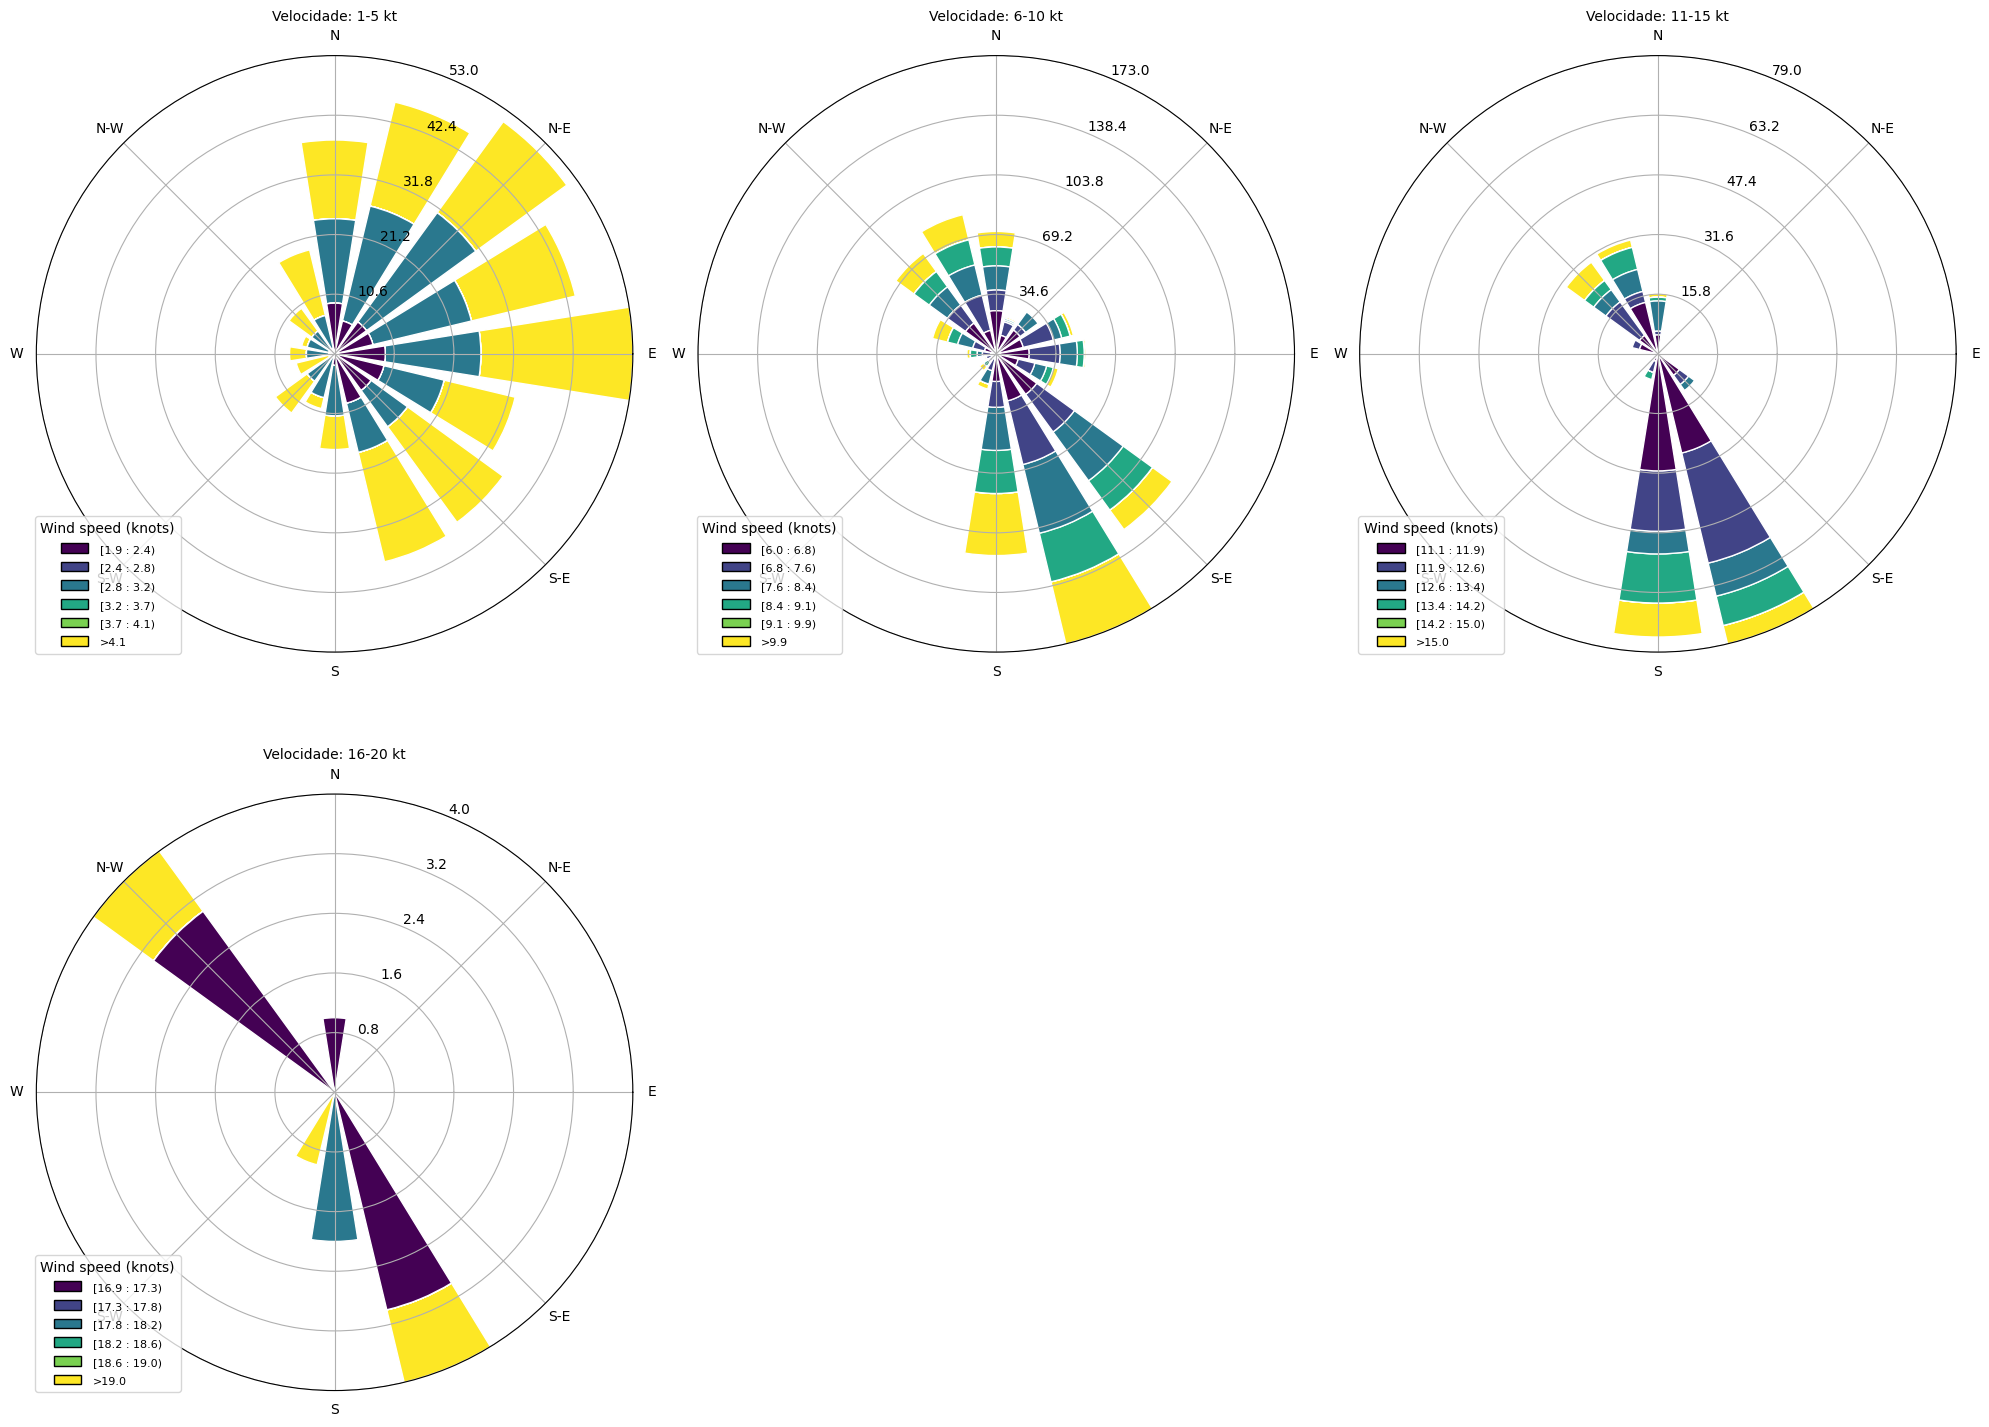

In [31]:
data = process_csv_data('../data')
plot_wind_roses(data)